## EDA and cleaning on scraped imdb.com data 

In [47]:
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = 'C:\\Users\\chris\\Downloads\\ODM_Group1\\imdb_output.json'           #importing the json file we got from the data scraping
df_raw = pd.read_json(path)

df_movies = df_raw[df_raw['title'].notna()].dropna(axis=1, how='all')             #Since the reviews and movies are all in one dataset, we want to split
df_reviews = df_raw[df_raw['reviewer_name'].notna()].dropna(axis=1, how='all')    #the json file into 2 dataframes so we can clean it.

In [ ]:
print(df_movies)          #Check and see if the splitting worked and how the 2 dataframes now look
print(df_movies.shape)

       movie_id                                     title  \
0    tt32642706                                   The Rip   
1    tt32141377           28 Years Later: The Bone Temple   
2    tt27543632                             The Housemaid   
3    tt30144839                  One Battle After Another   
4    tt31227572                        Predator: Badlands   
5    tt26443597                                Zootopia 2   
6     tt8036976                                 Send Help   
7    tt30343021                            Song Sung Blue   
8    tt27714581                         Sentimental Value   
59   tt33028778                                   Primate   
110  tt31187741                                 Torchwood   
161  tt35684666                Good Hang with Amy Poehler   
187  tt31590069                              Murder in HR   
213  tt31187724  Doctor Who: The Fourth Doctor Adventures   
239  tt33093512                The Best Man's Ghostwriter   
240  tt34192809         

In [ ]:
print(df_reviews)          #Here the same, but then for the reviews
print(df_reviews.shape)

       movie_id      reviewer_name   review_date  review_score  \
9    tt32642706        AshleyO-699  Jan 15, 2026           7.0   
10   tt32642706         adamcomito  Jan 17, 2026           6.0   
11   tt32642706           Fredolow  Jan 15, 2026           6.0   
12   tt32642706          qudaameer  Jan 15, 2026           NaN   
13   tt32642706           virindra  Jan 15, 2026           7.0   
..          ...                ...           ...           ...   
694  tt22740896           virindra   Jan 9, 2026           4.0   
695  tt22740896         daemoneyes   Jan 9, 2026           9.0   
696  tt22740896        riciurobert  Jan 17, 2026           6.0   
697  tt22740896  therealdinklebamp   Jan 9, 2026           3.0   
698  tt22740896        ThalerTimmi  Jan 18, 2026           7.0   

                                           review_text  
9    I almost didn't want to watch this picture, su...  
10   No doubt Ben and Matt had fun making this film...  
11   The Rip has the bones of an int

In [ ]:
movies_df = df_movies.drop_duplicates(subset=['movie_id', 'title'])   #Drops duplicates if there are, based ont the movie_id and title
reviews_df = df_reviews.drop_duplicates()                             #Here it droped duplicated reviews based on everything, since the movie_id can have multiple reviews.

In [ ]:
def clean_numeric(value):                        #Defining the function
    if pd.isna(value): return None               #Checks is the value is zero (NaN), if so, then it returns to none direct

    cleaned = re.sub(r'[^\d.]', '', str(value))  #This function stips everything, expect digits and decimal points
    return float(cleaned) if cleaned else None   #Converts to a float, or if it's empty then to none

In [ ]:
for col in ['budget', 'grossworldwide', 'openingweekend']:        #Defining the columns names for the next cleaning
    if col in df_movies.columns:                                   #Loops trough each of the above columns
        df_movies[col] = df_movies[col].apply(clean_numeric)      #It standardizes every numeric value

In [ ]:
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'], errors='coerce')   #Here we confort the dates into a datetime objects 
df_reviews['review_date'] = pd.to_datetime(df_reviews['review_date'], errors='coerce')   #We do this, because then we can pull data much easier from analysis
df_reviews['review_score'] = pd.to_numeric(df_reviews['review_score'], errors='coerce')  

In [ ]:
list_cols = ['writer', 'production_company', 'genres', 'roles', 'stars']    #defining the list-string columns
for col in list_cols:                                                    #Loops trough each of the above columns
    df_movies[col] = df_movies[col].apply(lambda x: ast.literal_eval(x) #Uses literal_eval to convert list-strings into python lists, otherwise '[' will be seen as a item in the string
        if isinstance(x, str) and x.startswith('[') else x)        #Wil only convert if it's a string and strats with a bracket 

In [ ]:
def parse_duration(duration_str):    #Here we convert the duration time into total minutes, so from '1h 50m' into '110'.
    if pd.isna(duration_str): return None      #If the value is zero (NaN), then it returns to none directly
    hours = 0          #Set the default starting point
    minutes = 0       #Set the default starting point
    h_match = re.search(r'(\d+)h', str(duration_str))   #searches for the hours in the column trough the letter 'h'
    m_match = re.search(r'(\d+)m', str(duration_str))   #Here the same for minutes 'm'
    if h_match: hours = int(h_match.group(1))         #If it was found, then it will extract the number out of it
    if m_match: minutes = int(m_match.group(1))       #Here the same as above
    return (hours * 60) + minutes                   #Calculates the total minutes 

df_movies['duration_minutes'] = df_movies['duration'].apply(parse_duration)  #creates a new column with the total minutes

### Now that we've done cleaning on the 2 dataframes, we can do some eda on it;

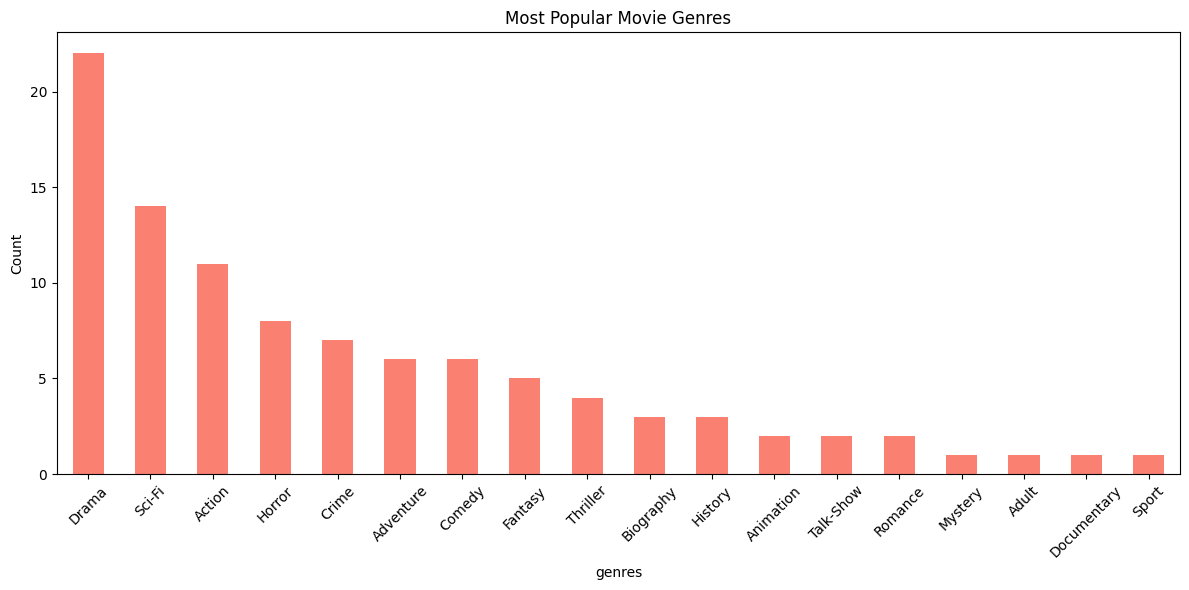

In [ ]:
plt.figure(figsize=(12, 6))
genres_exploded = movies_df.explode('genres')   #We "explode" the list of genres so each genre gets its own row
genres_exploded['genres'].value_counts().plot(kind='bar', color='salmon')
plt.title('Most Popular Movie Genres')         #We plot the genres movies that are most seen in the movies, so we can get the most popular genres
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('genre_frequency.png')

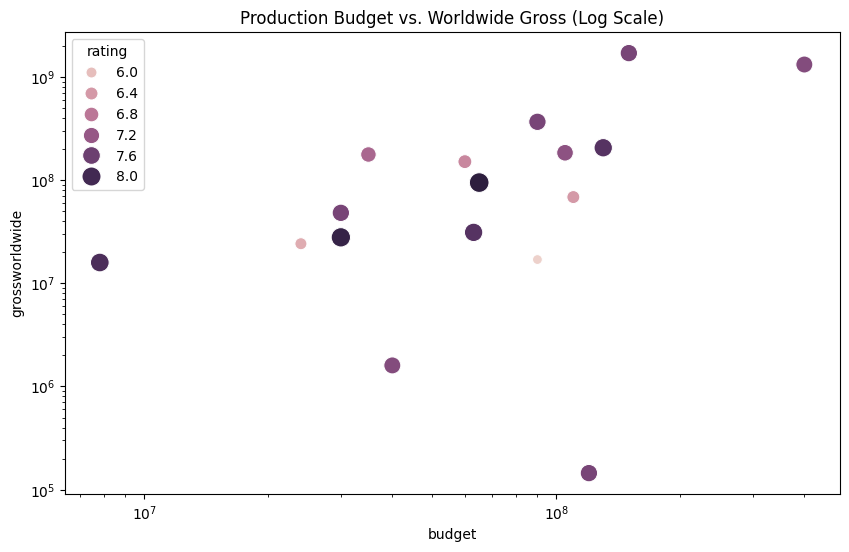

In [49]:
# 7. EDA: Budget vs. Gross (Financial Performance)
# Filter out movies that don't have budget or gross data
financial_data = movies_df.dropna(subset=['budget', 'grossworldwide'])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=financial_data, x='budget', y='grossworldwide', hue='rating', size='rating', sizes=(50, 200))
plt.title('Production Budget vs. Worldwide Gross (Log Scale)')
plt.xscale('log')
plt.yscale('log')
plt.savefig('budget_vs_gross.png')

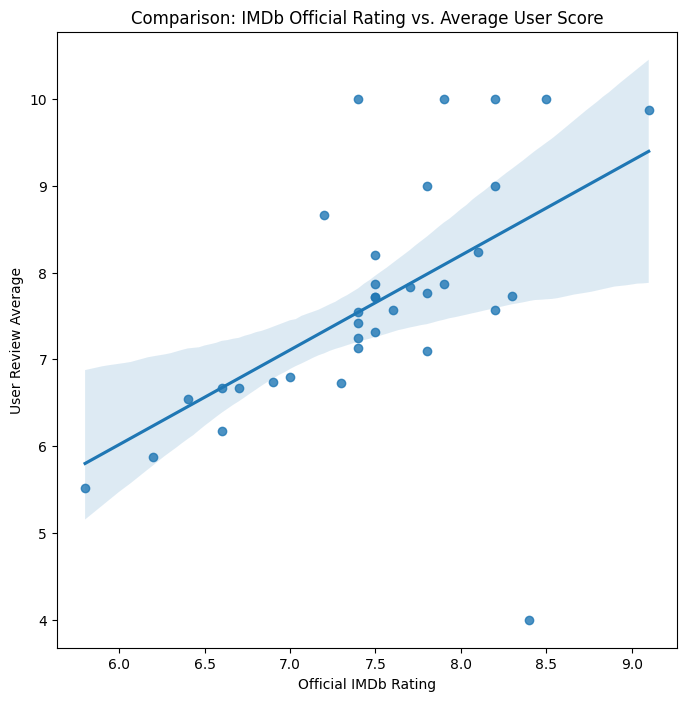

In [51]:
# 8. EDA: Comparing IMDb Rating vs. Average User Score
avg_user_scores = reviews_df.groupby('movie_id')['review_score'].mean().reset_index()
merged_perf = movies_df.merge(avg_user_scores, on='movie_id')

plt.figure(figsize=(8, 8))
sns.regplot(data=merged_perf, x='rating', y='review_score')
plt.title('Comparison: IMDb Official Rating vs. Average User Score')
plt.xlabel('Official IMDb Rating')
plt.ylabel('User Review Average')
plt.savefig('rating_comparison.png')

In [52]:
# 9. SAVE FINAL CLEANED DATA
movies_df.to_csv('movies_final_cleaned.csv', index=False)
reviews_df.to_csv('reviews_final_cleaned.csv', index=False)
print("complete!")

complete!
